In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


<Client: scheduler='inproc://10.0.64.18/28730/1' processes=1 cores=8>

In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [4]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [5]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [6]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

Index: 
* Max Severity 
* Max SSTA 
* Number of MHW Days 
* All plotted together, Changes in Mean state

## Finding mean of the max severity per year in future and past MHWs
This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the top of the model, which seemed to give some weird results.

In [7]:
%%time
maxFutSev = futMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

CPU times: user 17.8 s, sys: 13.1 s, total: 30.8 s
Wall time: 58.1 s


In [8]:
%%time 
maxPastSev = pastMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

CPU times: user 16.2 s, sys: 16.4 s, total: 32.6 s
Wall time: 54.4 s


In [9]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

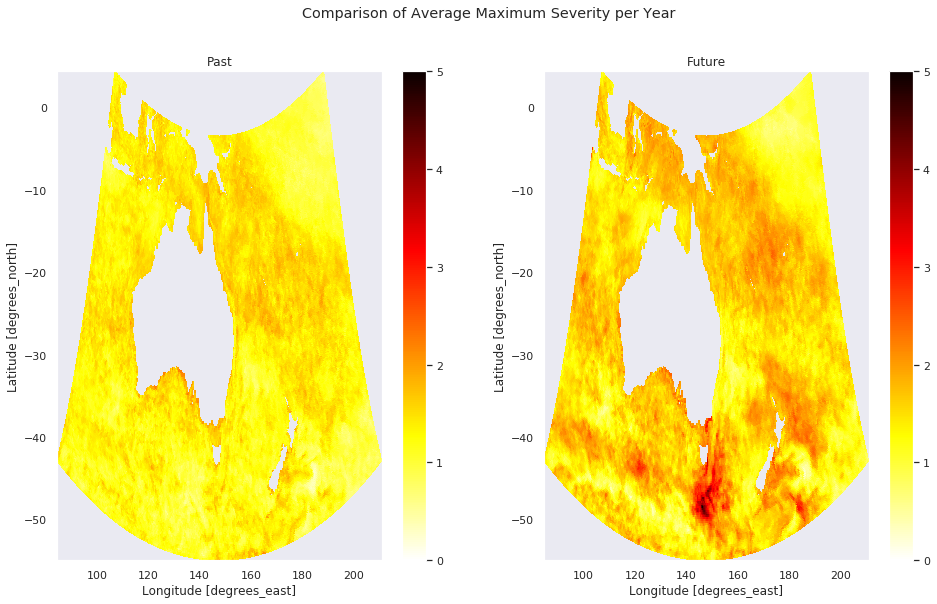

In [10]:
vmin = 0; vmax = 5;
f, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,9))
f.suptitle('Comparison of Average Maximum Severity per Year')
maxPastSev.plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSev.plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

ax1.set_title('Past')

ax2.set_title('Future');
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSeverityPerYear.png')

In [276]:
# Difference between past and future maximums.
max_diff = maxFutSev - maxPastSev

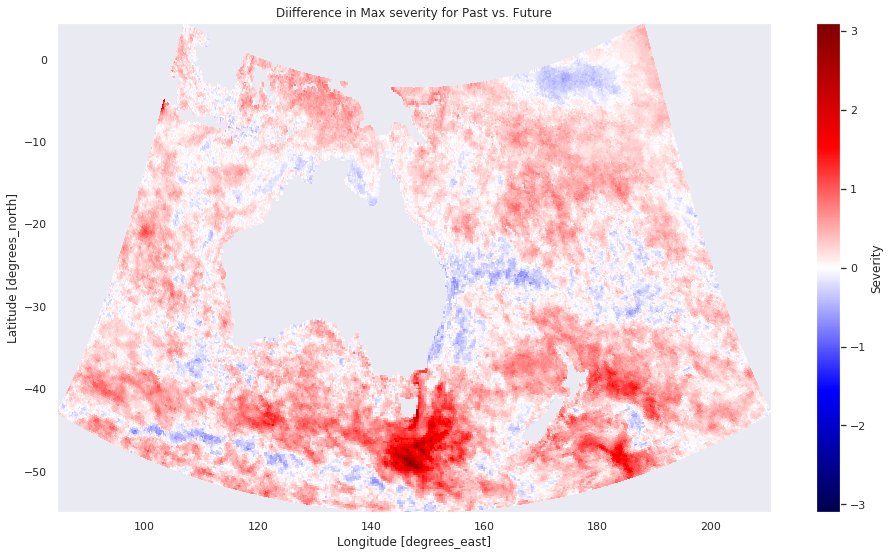

In [283]:
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', cbar_kwargs = {'label' : 'Severity'});
plt.title('Diifference in Max severity for Past vs. Future');

### Histogram

In [75]:
# Grid file contains the x and y size for each grid box within our model
grid = xr.open_dataset('/g/data1/e14/gs9353/NOW_OUTPUTS/MESH/mesh_mask_cordex24.nc')
gridx = grid['e1t'].isel(t= 0)
gridy = grid['e2t'].isel(t= 0)
# Assuming locally flat geometry, we can calculate the area at each grid cell
area = gridx * gridy
# As we have removed some of our model data, we remove the same portion from the calculated area
area = area.isel(x = slice(5,-5), y = slice(5,-50))
# Calculates the weights required for the below section
weights = area / area.max()

In [76]:
# Calculates the median the area weights future and past Severity
past_median = (maxPastSev * weights).median().data
fut_median = (maxFutSev* weights).median().data
# Creates a time series that can be used alongside a histogram to show the change in median
y = np.linspace(0,1.5)
past_median_series = np.full_like(y, past_median)
fut_median_series = np.full_like(y, fut_median)

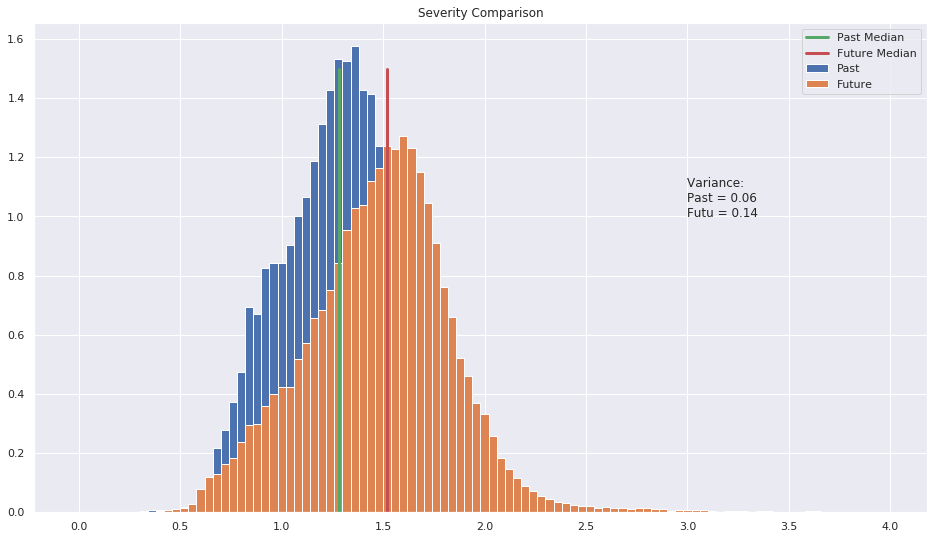

In [77]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,4,101)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

(maxPastSev*weights).plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
(maxFutSev*weights).plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
plt.plot(past_median_series, y, 'g',label = 'Past Median', linewidth = 3)
plt.plot(fut_median_series, y, 'r',label = 'Future Median', linewidth = 3)

past_var = np.round(maxPastSev.var().data,2)
fut_var = np.round(maxFutSev.var().data,2)
var_str = ('Variance: \nPast = {0} \nFutu = {1}').format(past_var, fut_var)
plt.text(3.0, 1, var_str)


plt.legend()
'''
ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
''';
plt.title('Severity Comparison');
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSeverityPerYear_hist_withStats.png')

### Significance  

In [10]:
sev_diff = maxFutSev - maxPastSev

In [12]:
# Opens wind speeds and removes troublesome areas
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
u = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_U_2D_mean.nc')['uos'].isel(x = slice(5,-5), y = slice(5,-50))
v = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_V_2D_mean.nc')['vos'].isel(x = slice(5,-5), y = slice(5,-50))

u['nav_lon'] = u['nav_lon'] % 360  
v['nav_lon'] = v['nav_lon'] % 360  

In [13]:
udif = u.sel(simulation = 'Future') - u.sel(simulation = 'Present') 
vdif = v.sel(simulation = 'Future') - v.sel(simulation = 'Present') 

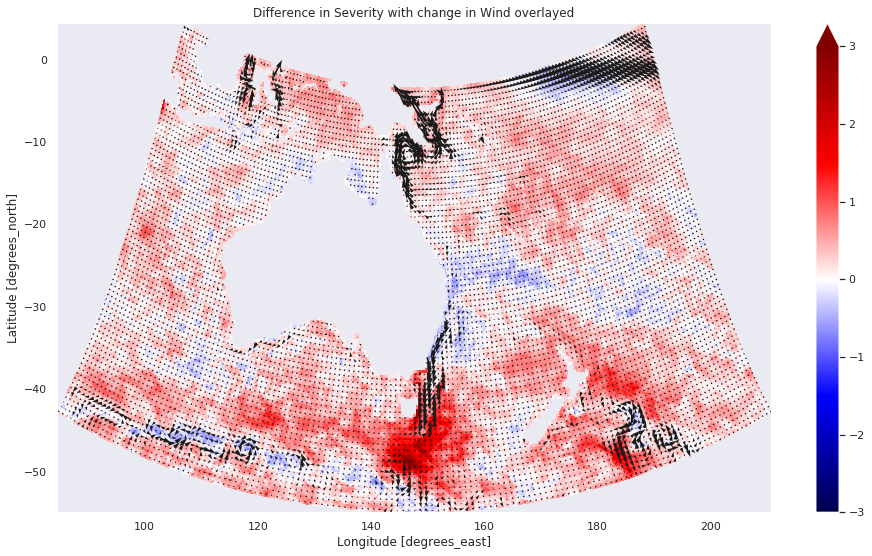

In [18]:
fig, ax = plt.subplots(figsize = (16,9))
sev_diff.plot(x = 'nav_lon', y = 'nav_lat', vmin = -3, vmax = 3, cmap = 'seismic', ax = ax);
skip = 3
ax.quiver(udif['nav_lon'][::skip, ::skip], vdif['nav_lat'][::skip, ::skip], udif[::skip, ::skip], vdif[::skip, ::skip], pivot='middle', angles='xy', scale_units='xy',  scale = 0.12);
#plt.xlim(140); plt.ylim(-55,-10);
#ax.set_aspect('equal')
plt.title('Difference in Severity with change in Wind overlayed');
plt.savefig('/home/561/rm6294/Documents/Winds/wind_direction_every3.png')

In [13]:
maxPastSev_year = pastMHW.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))
maxFutSev_year = futMHW.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))

In [15]:
(t, sev_pValue)  = stats.ttest_rel(maxPastSev_year, maxFutSev_year)
sev_sig = np.where(sev_pValue > 0.05, np.nan, sev_pValue) 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


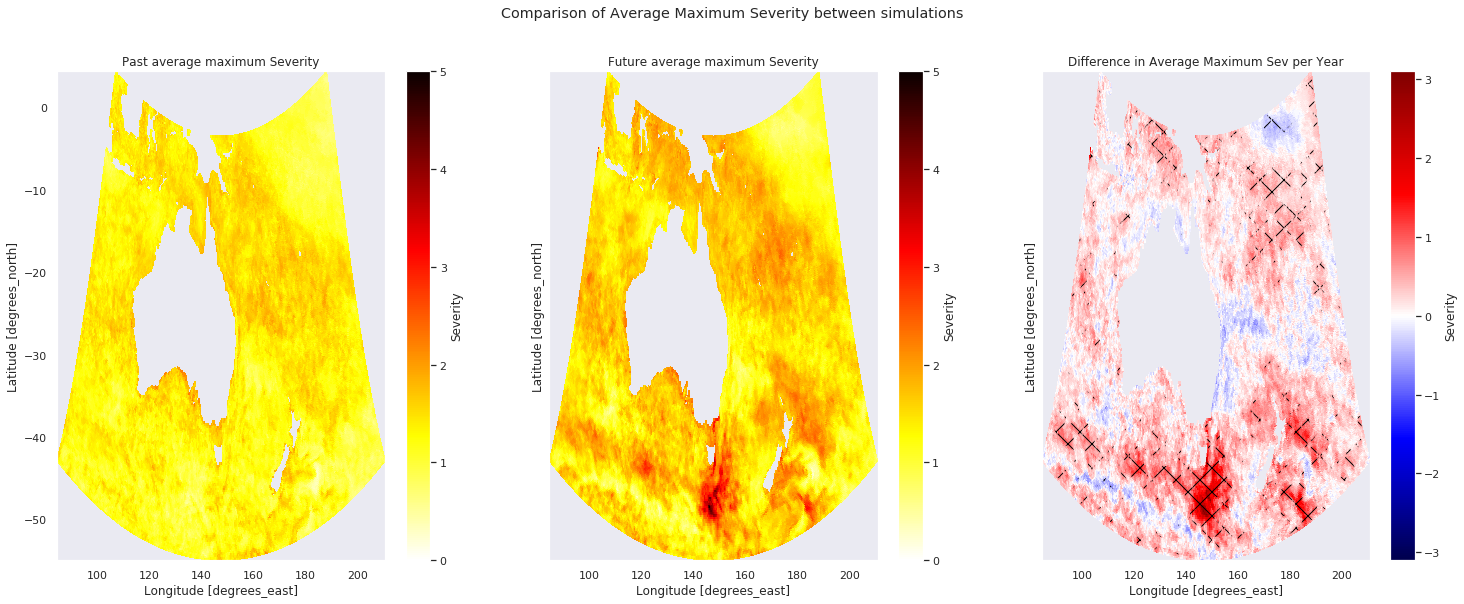

In [27]:
f, axes = plt.subplots(1,3, sharey = True, figsize = [25, 9])
f.suptitle('Comparison of Average Maximum Severity between simulations')
#Past and Future plots
vmin, vmax = (0, 5)
maxPastSev.plot(cmap = 'hot_r', ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Severity'});
maxFutSev.plot(cmap = 'hot_r',ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Severity'});
axes[0].set_title('Past average maximum Severity')
axes[1].set_title('Future average maximum Severity')
# Difference plots
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
sev_diff.plot(cmap = 'seismic',x = 'nav_lon', y = 'nav_lat', ax = axes[2], cbar_kwargs = {'label' : 'Severity'})
plt.contourf(sev_diff['nav_lon'], sev_diff['nav_lat'], sev_sig, levels = [0,0.05], hatches=['\/'], colors = 'none');
axes[2].set_title('Difference in Average Maximum Sev per Year');
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSev_all3')

### Seasonal

In [404]:
maxPastSev_seas = pastMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSev_seas = futMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()

In [405]:
maxSev_diff_seas = maxFutSev_seas - maxPastSev_seas

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

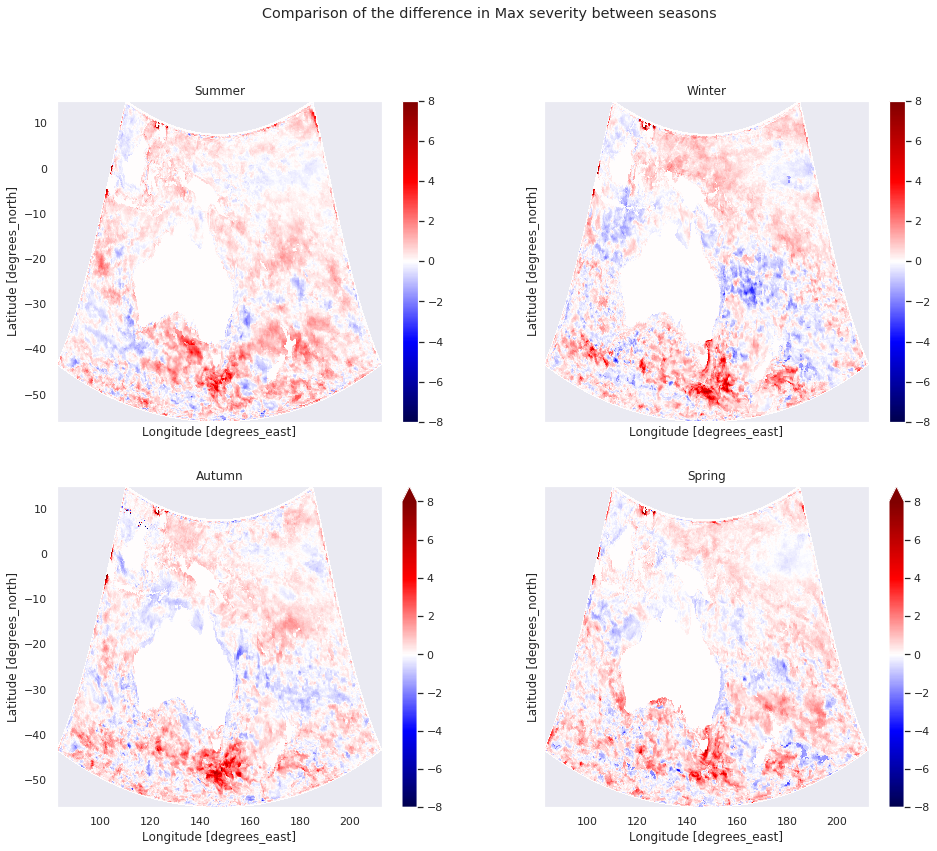

In [482]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max severity between seasons')
vmin, vmax = (-8, 8)
i = 0
for ax in axes.flat:
    maxSev_diff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for positve values (implies future shallower than past)
#plt.savefig('/home/561/rm6294/Documents/Statisitics_Plots/maxSev_seas.png')

### Calculating statistics for maximum Severity

In [98]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [45]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.25 , var = 0.06 , mean = 1.3 , median = 1.33 , iqr = 0.36
Futu: std = 0.38 , var = 0.14 , mean = 1.56 , median = 1.57 , iqr = 0.47


## Max SSTA

In [7]:
cfg = 'present_vs_future.ini'
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos']

In [63]:
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [73]:
'''sstPast = sst.sel(simulation = 'Present')
sstFut = sst.sel(simulation = 'Future')
'''
# ^ as Guillaume has movedf the file
sstPast = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_v1/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')
sstFut = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_ALL/cordex24-BMJv2_BILAP_ALL_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Future')

In [74]:
# Finding anomaly
sstaPast = sstPast.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - pClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})
sstaFut = sstFut.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - fClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})

In [75]:
%%time
# Finding max SSTA
maxFutSSTA = sstaFut.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute() 
maxFutSSTA['nav_lon'] = maxFutSSTA['nav_lon'] % 360

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 41.7 s, sys: 1min 43s, total: 2min 24s
Wall time: 21.4 s


In [76]:
%%time
maxPastSSTA = sstaPast.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
maxPastSSTA['nav_lon'] = maxPastSSTA['nav_lon'] % 360

CPU times: user 42.6 s, sys: 1min 45s, total: 2min 28s
Wall time: 22.1 s


In [79]:
# Replaces land masses with nan as opposed to 0 value
maxPastSSTA = xr.where(maxPastSSTA == 0, np.nan, maxPastSSTA)
maxFutSSTA = xr.where(maxFutSSTA == 0, np.nan, maxFutSSTA)

In [80]:
# This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the 
# top of the model, which seemed to give some weird results.
maxPastSSTA = maxPastSSTA.isel(x = slice(5,-5), y = slice(5,-50))
maxFutSSTA = maxFutSSTA.isel(x = slice(5,-5), y = slice(5,-50))

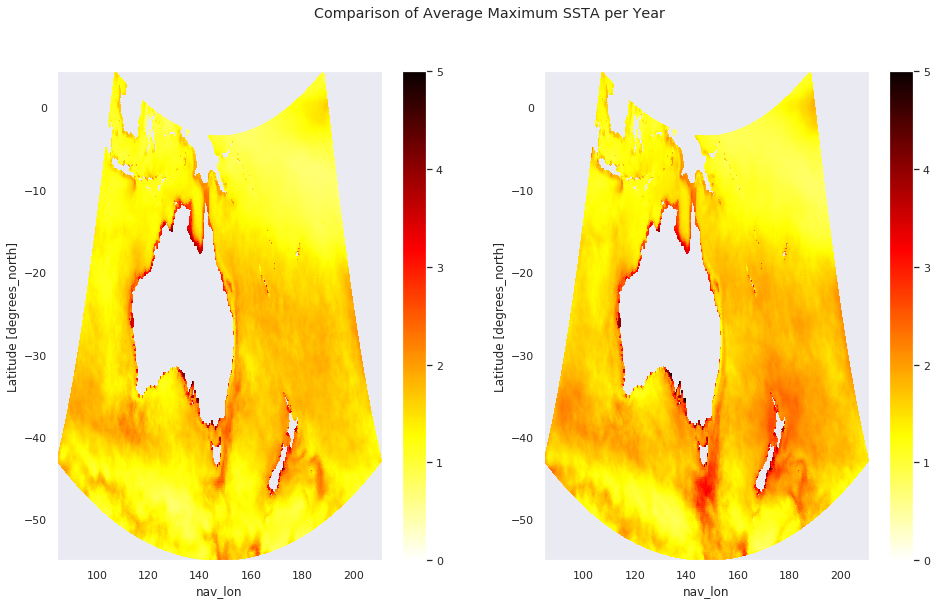

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 5)
maxPastSSTA.plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSSTA.plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
plt.suptitle('Comparison of Average Maximum SSTA per Year');
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSSTAPerYear')

### Histogram 

In [264]:
# Calculates the median the area weights future and past SSTA
past_median = (maxPastSSTA * weights).median().data
fut_median = (maxFutSSTA* weights).median().data
# Creates a time series that can be used alongside a histogram to show the change in median
y = np.linspace(0,1.15)
past_median_series = np.full_like(y, past_median)
fut_median_series = np.full_like(y, fut_median)

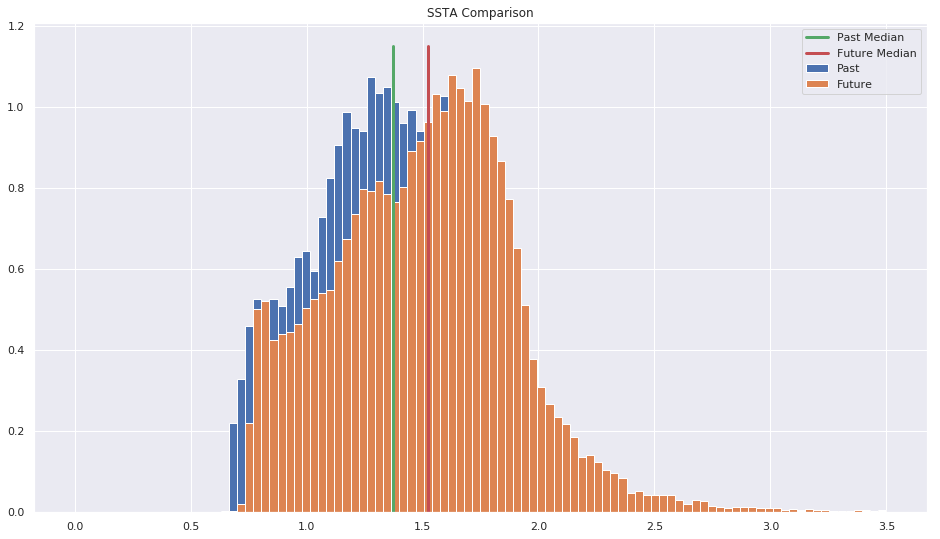

In [266]:
# Plots the frequencies/frequency density for each SSTA. 
bins = np.linspace(0, 3.5, 101)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

(maxPastSSTA * weights).plot.hist(bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
(maxFutSSTA * weights).plot.hist(bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
# Plotting medians
plt.plot(past_median_series, y, 'g',label = 'Past Median', linewidth = 3)
plt.plot(fut_median_series, y, 'r',label = 'Future Median', linewidth = 3)
plt.legend()
'''
ax1.set_title('Past Max SSTA')
ax1.grid(True)
ax1.set_xlabel('SSTA [$^o C$]')

ax2.set_title('Future Max SSTA');
ax2.grid(True);
ax2.set_xlabel('SSTA [$^o C$]');
'''
plt.title('SSTA Comparison')
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxSSTAPerYear_hist')

### Significance  

In [85]:
SSTA_diff = maxFutSSTA - maxPastSSTA

In [82]:
maxPastSSTA_year = sstaPast.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))
maxFutSSTA_year = sstaFut.groupby('time_counter.year').max(dim = 'time_counter').isel(x = slice(5,-5), y = slice(5,-50))

In [83]:
(t, ssta_pValue)  = stats.ttest_rel(maxPastSSTA_year, maxFutSSTA_year)
ssta_sig = np.where(ssta_pValue > 0.05, np.nan, ssta_pValue) 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/g/data1/e14/rm6294/minicond

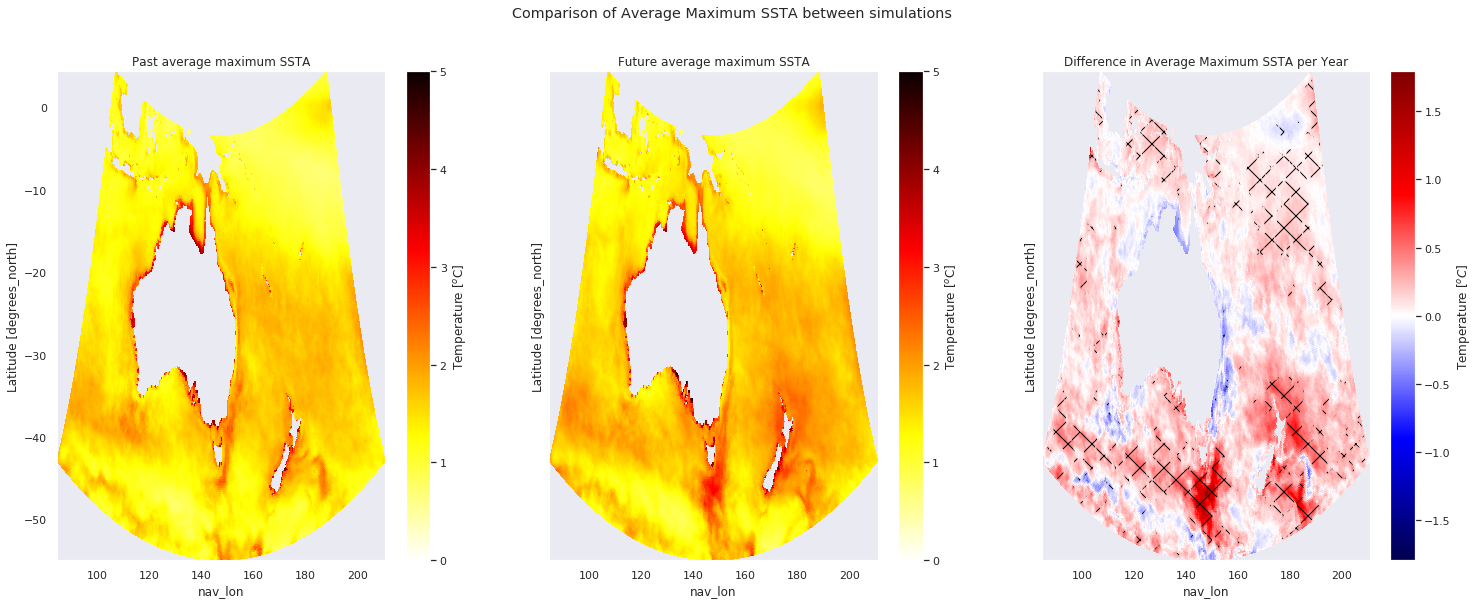

In [97]:
f, axes = plt.subplots(1,3, sharey = True, figsize = [25, 9])
f.suptitle('Comparison of Average Maximum SSTA between simulations')
#Past and Future plots
vmin, vmax = (0, 5)
maxPastSSTA.plot(cmap = 'hot_r', ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});
maxFutSSTA.plot(cmap = 'hot_r',ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cbar_kwargs = {'label' : 'Temperature [$^o$C]'});
axes[0].set_title('Past average maximum SSTA')
axes[1].set_title('Future average maximum SSTA')
# Difference plots
y = np.linspace(0,234, 234)
x = np.linspace(0,421, 421)
SSTA_diff.plot(cmap = 'seismic',x = 'nav_lon', y = 'nav_lat', ax = axes[2], cbar_kwargs = {'label' : 'Temperature [$^oC$]'})
plt.contourf(SSTA_diff['nav_lon'], SSTA_diff['nav_lat'], ssta_sig, levels = [0,0.05], hatches=['\/'], colors = 'none');
axes[2].set_title('Difference in Average Maximum SSTA per Year');
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/aveMaxDif_all3')

### Seasonal Plots

In [407]:
maxPastSSTA_seas = sstaPast.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSSTA_seas = sstaFut.groupby('time_counter.season').max(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [466]:
maxSSTA_diff_seas = maxFutSSTA_seas - maxPastSSTA_seas
maxSSTA_diff_seas['nav_lon'] = maxSSTA_diff_seas['nav_lon'] % 360
maxSSTA_diff_seas = maxSSTA_diff_seas.isel(x = slice(5,-5), y = slice(5, -50))
# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

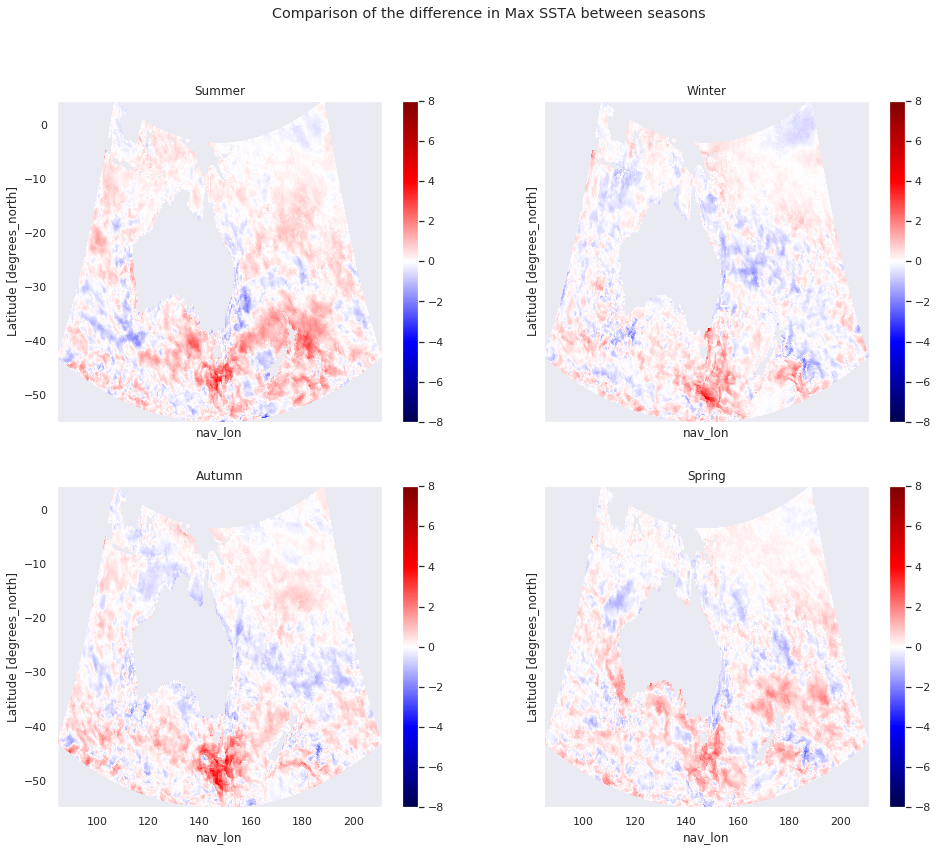

In [483]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max SSTA between seasons')
vmin, vmax = (-8, 8)
i = 0
for ax in axes.flat:
    maxSSTA_diff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/maxSSTA_seas.png')

## Counting number of MHW days in each simulation

In [50]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()

In [51]:
# Same as above
futDays = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
futDays = xr.where(futDays == 0, np.nan, futDays).compute()

In [30]:
print(futDays.sum().data/ pastDays.sum().data)
# Increase of 16% in MHW days!

1.1555577299555588


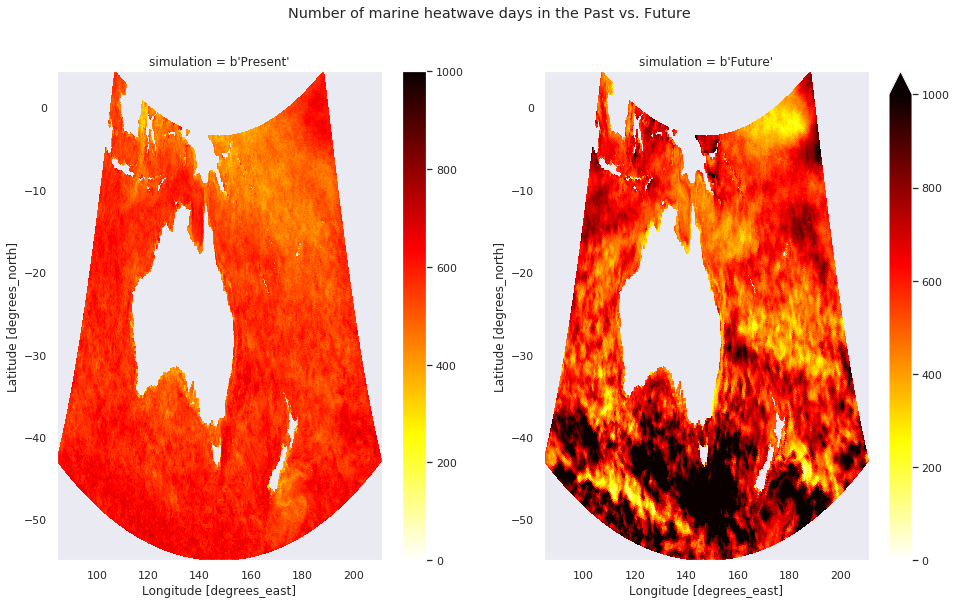

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 1000)
f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'hot_r');
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax2, vmin = vmin, vmax = vmax, cmap = 'hot_r');

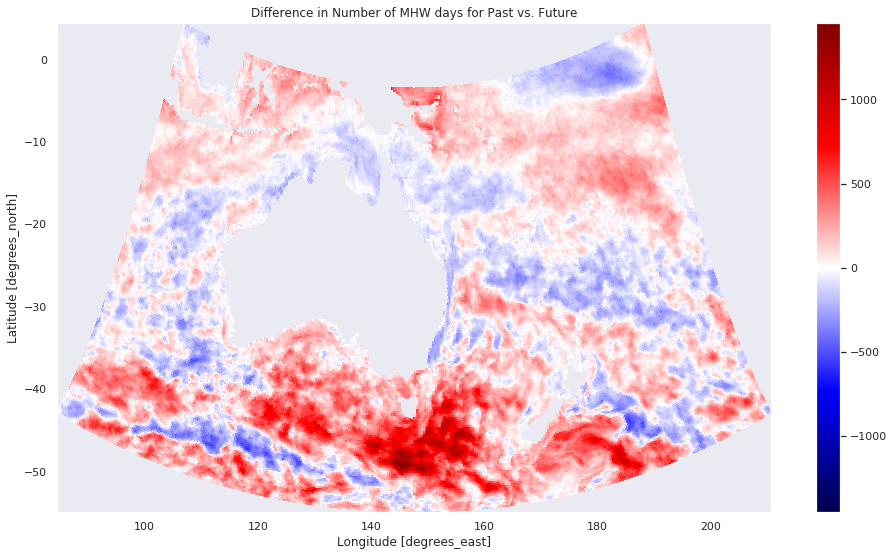

In [34]:
(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');
plt.title('Difference in Number of MHW days for Past vs. Future');

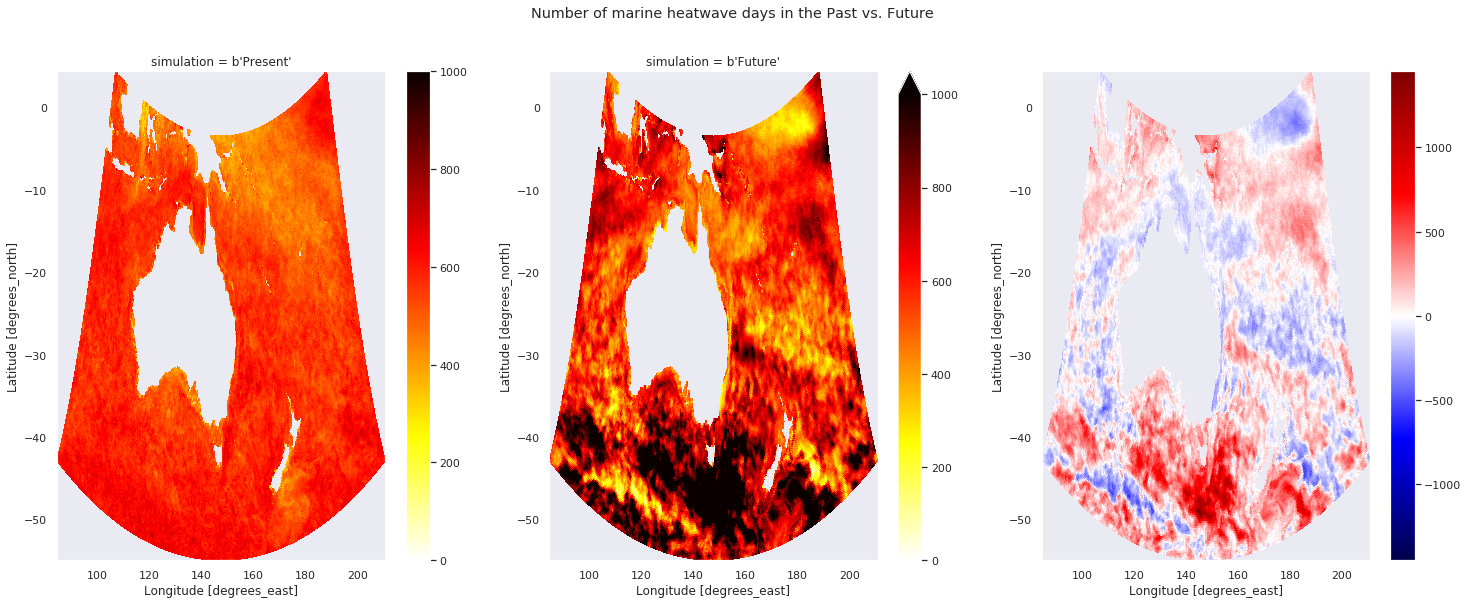

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 9))
vmin, vmax = (0, 1000)
f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'hot_r');
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax2, vmin = vmin, vmax = vmax, cmap = 'hot_r');
(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax3);
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/days_all3')

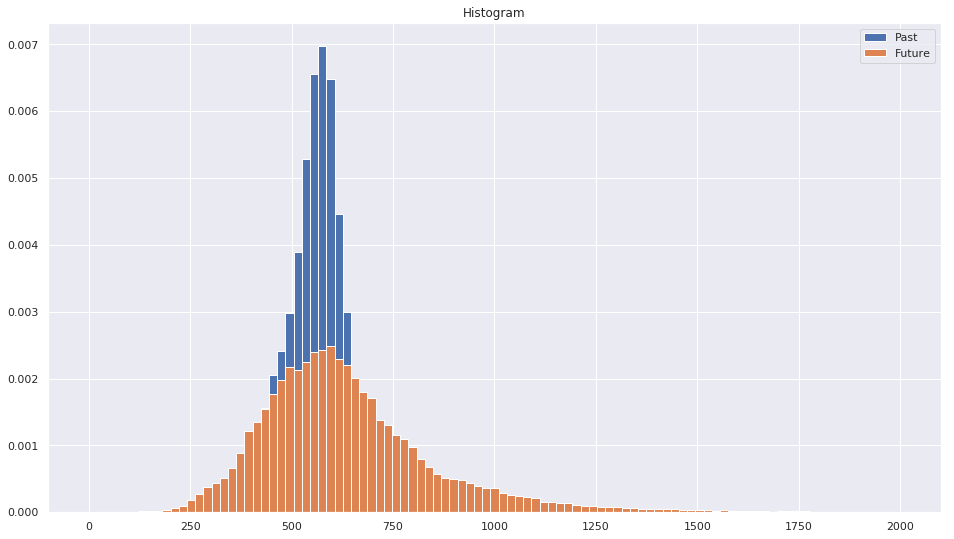

In [54]:
# Plots the frequencies/frequency density for # of days. 
bins = np.linspace(0,2000,100)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

pastDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Past')#, ax = ax1);
futDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Future')#, ax = ax2);
plt.legend()
'''
ax1.set_title('Past')
ax1.grid(True)
ax1.set_xlabel('# of MHW days')

ax2.set_title('Future');
ax2.grid(True);
ax2.set_xlabel('# of MHW days');
''';

In [445]:
pastDays_seas = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays_seas = xr.where(pastDays_seas == 0, np.nan, pastDays_seas).compute()

In [460]:
futDays_seas = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
futDays_seas = xr.where(futDays_seas == 0, np.nan, futDays_seas).compute()

In [468]:
daysDiff_seas = futDays_seas - pastDays_seas

# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

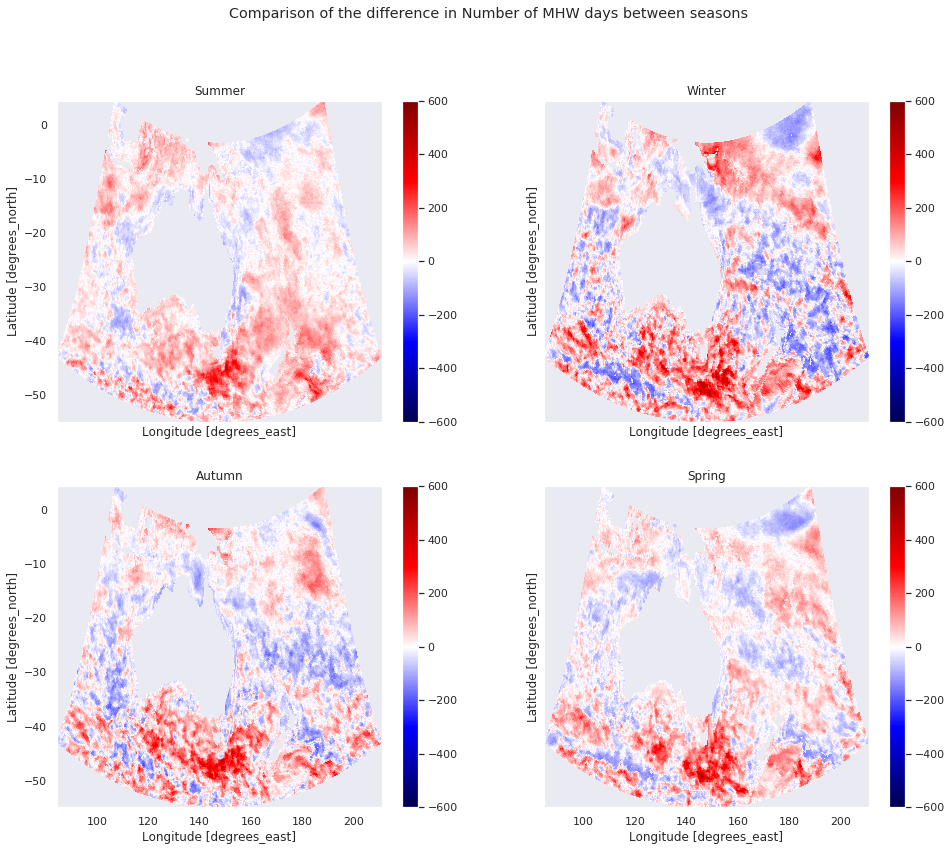

In [477]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Number of MHW days between seasons')
vmin, vmax = (-600, 600)
i = 0
for ax in axes.flat:
    daysDiff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
#plt.savefig('/home/561/rm6294/Documents/maxSSTA_seas.png')

## Differences plotted together

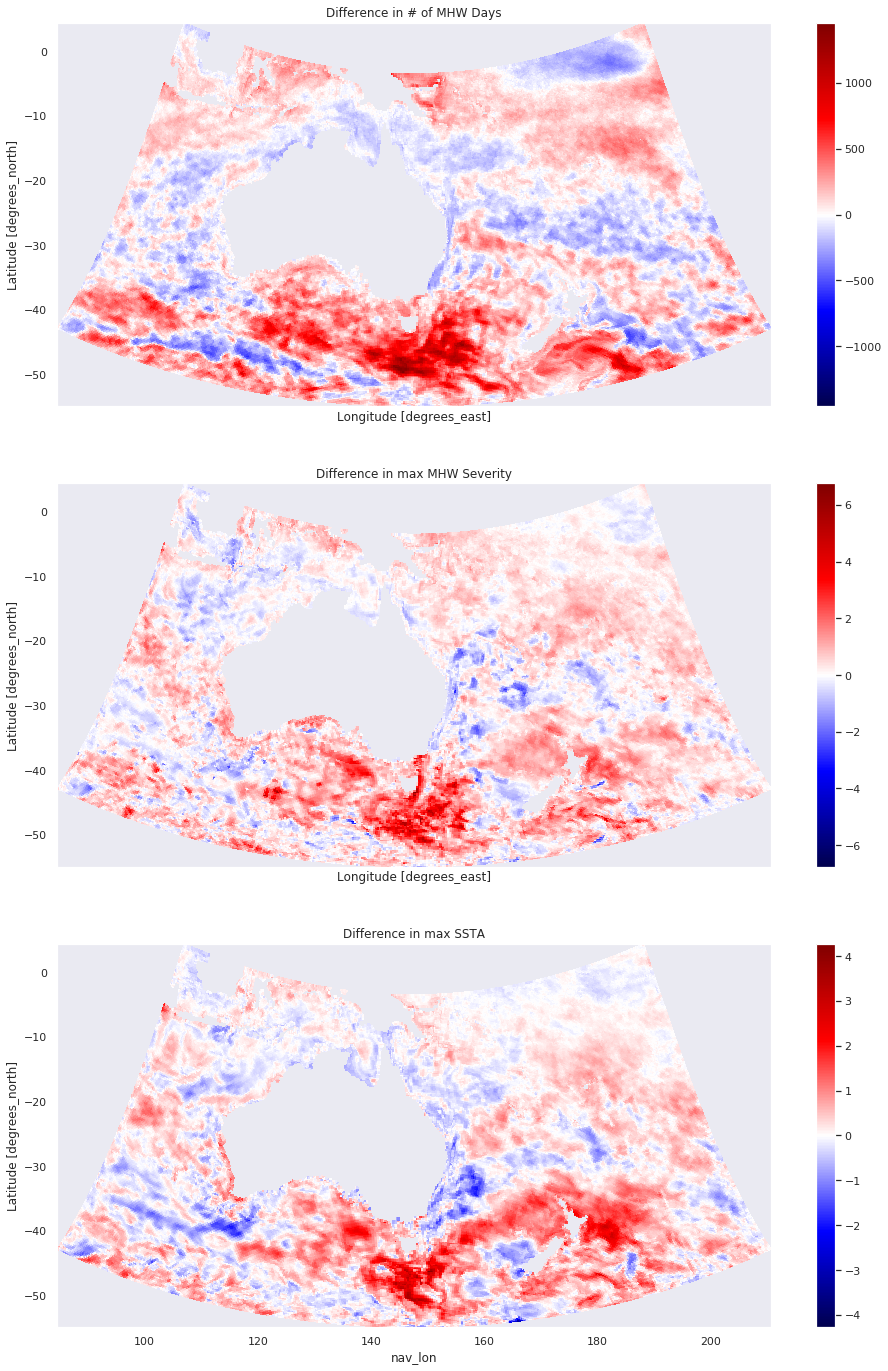

In [377]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize = (16,24))
#f.suptitle('Comparison of metrics in the Past vs. Future');

(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax1)
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax2)
SSTA_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax3)


ax1.set_title('Difference in # of MHW Days')
ax2.set_title('Difference in max MHW Severity')
ax3.set_title('Difference in max SSTA');
plt.savefig('/home/561/rm6294/Documents/diff_in_metrics.png')

## Regional Plots

#### Tasman Region
lat = -30N to -50N 

lon = 120E to 180E

In [58]:
# x = 421, y = 234, nav_lon = 84.7 to 188.2, nav_lat = -42.8 to 4.3
maxPastSev.isel(y = slice(int(120/421 * (188.2 - 84.7)), int(180/421 * (188.2 - 84.7))))

<xarray.DataArray (y: 15, x: 421)>
array([[1.375178, 1.288311, 1.430875, ..., 0.958522, 1.010215, 1.077726],
       [1.288646, 1.246535, 1.317052, ..., 0.882433, 0.906309, 1.072705],
       [1.184282, 1.21984 , 1.334826, ..., 0.961842, 0.939206, 1.062157],
       ...,
       [1.409687, 1.490363, 1.38475 , ..., 0.95079 , 1.027277, 1.162715],
       [1.545648, 1.385928, 1.444714, ..., 0.962925, 1.129862, 1.263271],
       [1.617188, 1.444959, 1.601606, ..., 1.028653, 1.156529, 1.307755]])
Coordinates:
    nav_lat     (y, x) float32 -37.165447 -37.258785 ... -34.492474 -34.40083
    nav_lon     (y, x) float32 88.58756 88.82143 ... 204.76688 204.99841
    simulation  |S7 b'Present'
Dimensions without coordinates: y, x

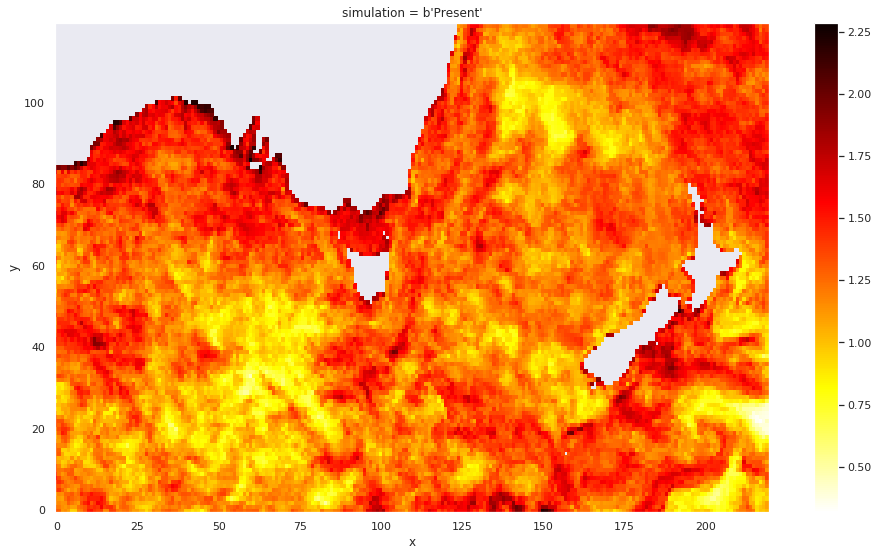

In [71]:
maxPastSev.isel(y = slice(0,120), x = slice(110, 330)).plot(cmap = 'hot_r');

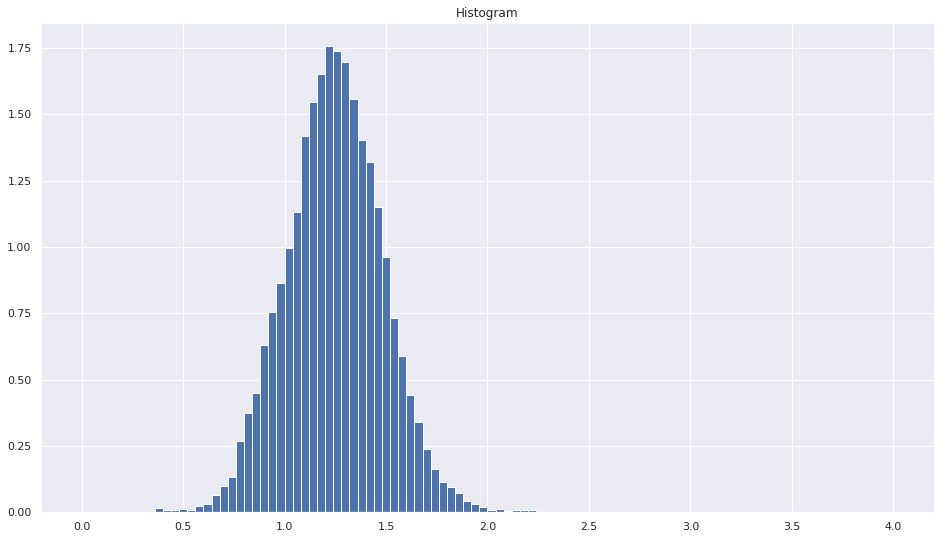

In [80]:
maxPastSev.isel(y = slice(0,120), x = slice(110, 330)).plot.hist(bins = bins, density = True);